In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

# Get data

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

In [4]:
all_illumina_cpg_locs_df = pd.read_csv(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"), sep=',', dtype={'CHR': str}, low_memory=False)
all_illumina_cpg_locs_df = all_illumina_cpg_locs_df.rename({"CHR": "chr", "MAPINFO":"start", "IlmnID": "#id"}, axis=1)
# get rows of all_illumina_cpg_locs_df where 'exon' appears in UCSC_RefGene_Group
all_illumina_cpg_locs_df.dropna(subset=['UCSC_RefGene_Group'], inplace=True)
exon_cpg_locs_df = all_illumina_cpg_locs_df[all_illumina_cpg_locs_df['UCSC_RefGene_Group'].str.contains('Body')]
cpg_in_body = exon_cpg_locs_df['Name'].to_list()

In [5]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min


In [ ]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)
# drop gender columns because most functions are not updated to work with this
all_methyl_age_df_t.drop(columns=['gender'], inplace=True)
all_mut_w_age_df.drop(columns=['gender'], inplace=True)

# Comethylation disturbance analysis

In [10]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 5, max_dist = 5000,
    num_correl_sites = 100, num_background_events = 100,
    matched_sample_num = 20
    )

In [18]:
rand_chrs = np.random.choice(list(CHROM_LENGTHS.keys()), size=100, replace=True)
rand_locs = [np.random.randint(0, CHROM_LENGTHS[chr]) for chr in rand_chrs]
rand_mut_events = pd.DataFrame({'chr': rand_chrs, 'start': rand_locs})


In [ ]:
mut_scan

In [36]:
# TODO: make sure background sites don't end up near real mutations in any sample
# TODO: what to do when background sites do not have comparison sites?
comparison_sites_df_test, all_metrics_df_test = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 25,
    linkage_method='dist', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    )

Number of mutation events being processed based on start_num_mut_to_process and end_num_mut_to_process: 25
Number of mutation events with at least one comparison site: 20


Getting matched samples: 100%|██████████| 20/20 [00:01<00:00, 13.86it/s]

Number mutation events being processed after filtering for matched sample number: 16



getting background sites:   0%|          | 0/16 [00:00<?, ?it/s]

<AxesSubplot:>

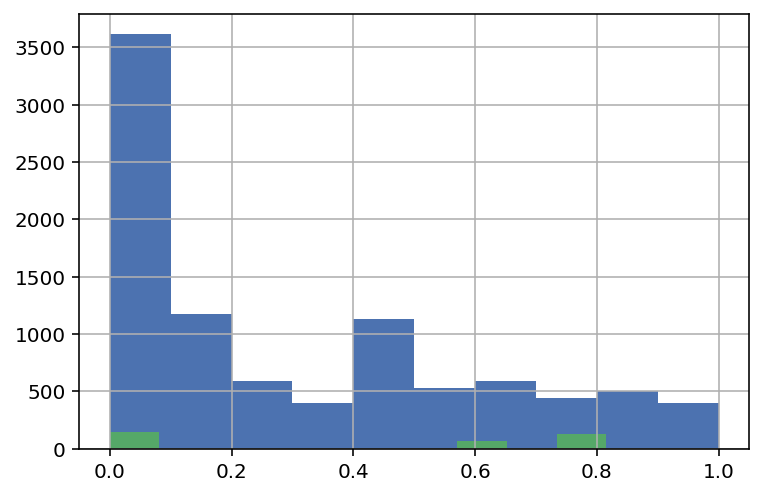

In [30]:
all_metrics_df_test.loc[all_metrics_df_test['is_background'] == True, 'delta_mf_pval2'].hist()
all_metrics_df_test.loc[all_metrics_df_test['is_background'] == False, 'delta_mf_pval2'].hist()

In [11]:
# took 6min for 8 fully processed events and 1000 correl sites
# took 4min for 8 fully processed events and 100 correl sites
comparison_sites_df_test, all_metrics_df_test = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 2,
    linkage_method='correl', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    )

Number mutation events being processed: 8576


Getting mut site delta MF: 100%|██████████| 6431/6431 [00:02<00:00, 2671.18it/s]

Number mutation events being processed after filtering for matched sample number: 2



getting background sites: 100%|██████████| 2/2 [01:24<00:00, 42.47s/it]


Wrote comparison sites df to /cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/comparison_sites_0-2Muts_100corrSites_pos_qnorm3SD_100background


Calculating effect of mutation on comparison sites: 100%|██████████| 202/202 [06:40<00:00,  1.98s/it]

Done getting effect of mutation on each site
got all metrics


writing results to /cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/all_metrics_0-2Muts_100corrSites_pos_qnorm3SD_100background


### Read in results

In [12]:
results_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/021323_comethylation_disturbance_output"
pos_all_metrics_dd = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_0-500Muts_100corrSites_pos_qnorm3SD_100background"))
pos_all_metrics_df = pos_all_metrics_dd.compute()
pos_comparison_sites_dd = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_0-500Muts_100corrSites_pos_qnorm3SD_100background"))
pos_comparison_sites_df = pos_comparison_sites_dd.compute()

# same but neg
neg_all_metrics_dd = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_0-500Muts_100corrSites_neg_qnorm3SD_100background"))
neg_all_metrics_df = neg_all_metrics_dd.compute()
neg_comparison_sites_dd = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_0-500Muts_100corrSites_neg_qnorm3SD_100background"))
neg_comparison_sites_df = neg_comparison_sites_dd.compute()

In [187]:

# read in all_metrics_df and comparison_sites_df
pos_all_metrics_dd2 = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_500-2500Muts_100corrSites_neg_qnorm3SD_0background"))
pos_all_metrics_df2 = pos_all_metrics_dd2.compute()
pos_comparison_sites_dd2 = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_500-2500Muts_100corrSites_neg_qnorm3SD_0background"))
pos_comparison_sites_df2 = pos_comparison_sites_dd2.compute()

pos_all_metrics_dd3 = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_2500-5000Muts_100corrSites_neg_qnorm3SD_0background"))
pos_all_metrics_df3 = pos_all_metrics_dd3.compute()
pos_comparison_sites_dd3 = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_2500-5000Muts_100corrSites_neg_qnorm3SD_0background"))
pos_comparison_sites_df3 = pos_comparison_sites_dd3.compute()

# same for neg
neg_all_metrics_dd2 = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_500-2500Muts_100corrSites_neg_qnorm3SD_0background"))
neg_all_metrics_df2 = neg_all_metrics_dd2.compute()
neg_comparison_sites_dd2 = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_500-2500Muts_100corrSites_neg_qnorm3SD_0background"))
neg_comparison_sites_df2 = neg_comparison_sites_dd2.compute()

neg_all_metrics_dd3 = dask.dataframe.read_parquet(os.path.join(results_dir, "all_metrics_2500-5000Muts_100corrSites_neg_qnorm3SD_0background"))
neg_all_metrics_df3 = neg_all_metrics_dd3.compute()
neg_comparison_sites_dd3 = dask.dataframe.read_parquet(os.path.join(results_dir, "comparison_sites_2500-5000Muts_100corrSites_neg_qnorm3SD_0background"))
neg_comparison_sites_df3 = neg_comparison_sites_dd3.compute()

In [188]:
# concat all metrics dfs
pos_all_metrics_comb_df = pd.concat([pos_all_metrics_df, pos_all_metrics_df2, pos_all_metrics_df3])
pos_comparison_sites_comb_df = pd.concat([pos_comparison_sites_df, pos_comparison_sites_df2, pos_comparison_sites_df3])
neg_all_metrics_comb_df = pd.concat([neg_all_metrics_df, neg_all_metrics_df2, neg_all_metrics_df3])
neg_comparison_sites_comb_df = pd.concat([neg_comparison_sites_df, neg_comparison_sites_df2, neg_comparison_sites_df3])

In [176]:
# sort pos_comparison_sites_comb_df by mut_delta_mf
pos_comparison_sites_comb_df.sort_values(by=['mut_delta_mf'], ascending=True, inplace=True)
big_mut_delta_events = pos_comparison_sites_comb_df.head(2000)['mut_event'].to_list()
# only keep metrics for these events

### P-value correction

In [189]:
# positive corr significance
pos_all_metrics_df_corrected = mut_scan.correct_pvals(pos_all_metrics_comb_df, one_background=True)
# negative corr significance
neg_all_metrics_df_corrected = mut_scan.correct_pvals(neg_all_metrics_comb_df, one_background=True)

In [191]:
real_muts = pos_all_metrics_comb_df.loc[
            (pos_all_metrics_comb_df['index_event'] == 'self') # redundant, makes sure not a background site
            & (pos_all_metrics_comb_df['mutated_sample'] == True) # makes sure is the mutated sample, for uniqueness
            & (pos_all_metrics_comb_df['is_background'] == False) # makes sure not a background site]
            & (pos_all_metrics_comb_df['mut_event'].isin(big_mut_delta_events)) # only keep events with big mut delta
            , : ]
real_mut_events = real_muts['mut_event'].unique()

In [183]:
# bonferroni correction
pos_all_metrics_df_corrected[['mf_pval2_sig_bonf', 'mf_pval_sig_bonf',
       'delta_mf_pval2_sig_bonf', 'delta_mf_pval_sig_bonf', 'abs_delta_mf_pval_sig_bonf']] = pos_all_metrics_df_corrected[['mf_pval2', 'mf_pval', 'delta_mf_pval2', 'delta_mf_pval', 'abs_delta_mf_pval']] < .05 / len(real_mut_events)

In [193]:
neg_all_metrics_df_corrected[['mf_pval2_sig_bonf', 'mf_pval_sig_bonf',
         'delta_mf_pval2_sig_bonf', 'delta_mf_pval_sig_bonf', 'abs_delta_mf_pval_sig_bonf']] = neg_all_metrics_df_corrected[['mf_pval2', 'mf_pval', 'delta_mf_pval2', 'delta_mf_pval', 'abs_delta_mf_pval']] < .05 / len(real_mut_events)

In [104]:
background_df = pos_all_metrics_comb_df.loc[
    (pos_all_metrics_comb_df['is_background'] == True) # get background samples
    & (pos_all_metrics_comb_df['mutated_sample'] == True) # and get just one of them
    , :].drop_duplicates(subset=['mut_event'])

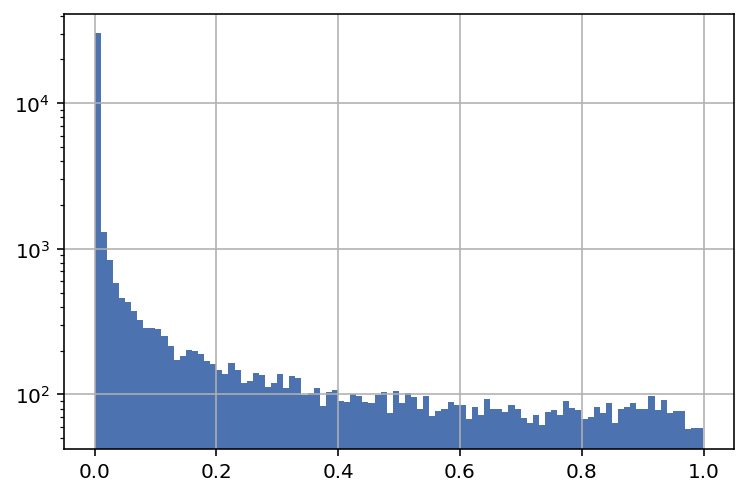

In [113]:
background_df['delta_mf_pval2'].hist(bins = 100)
plt.yscale('log')

#### Pos corr

##### Bonferroni

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_muts_df['abs_delta_mf_median'] = real_muts_df['delta_mf_median'].abs()


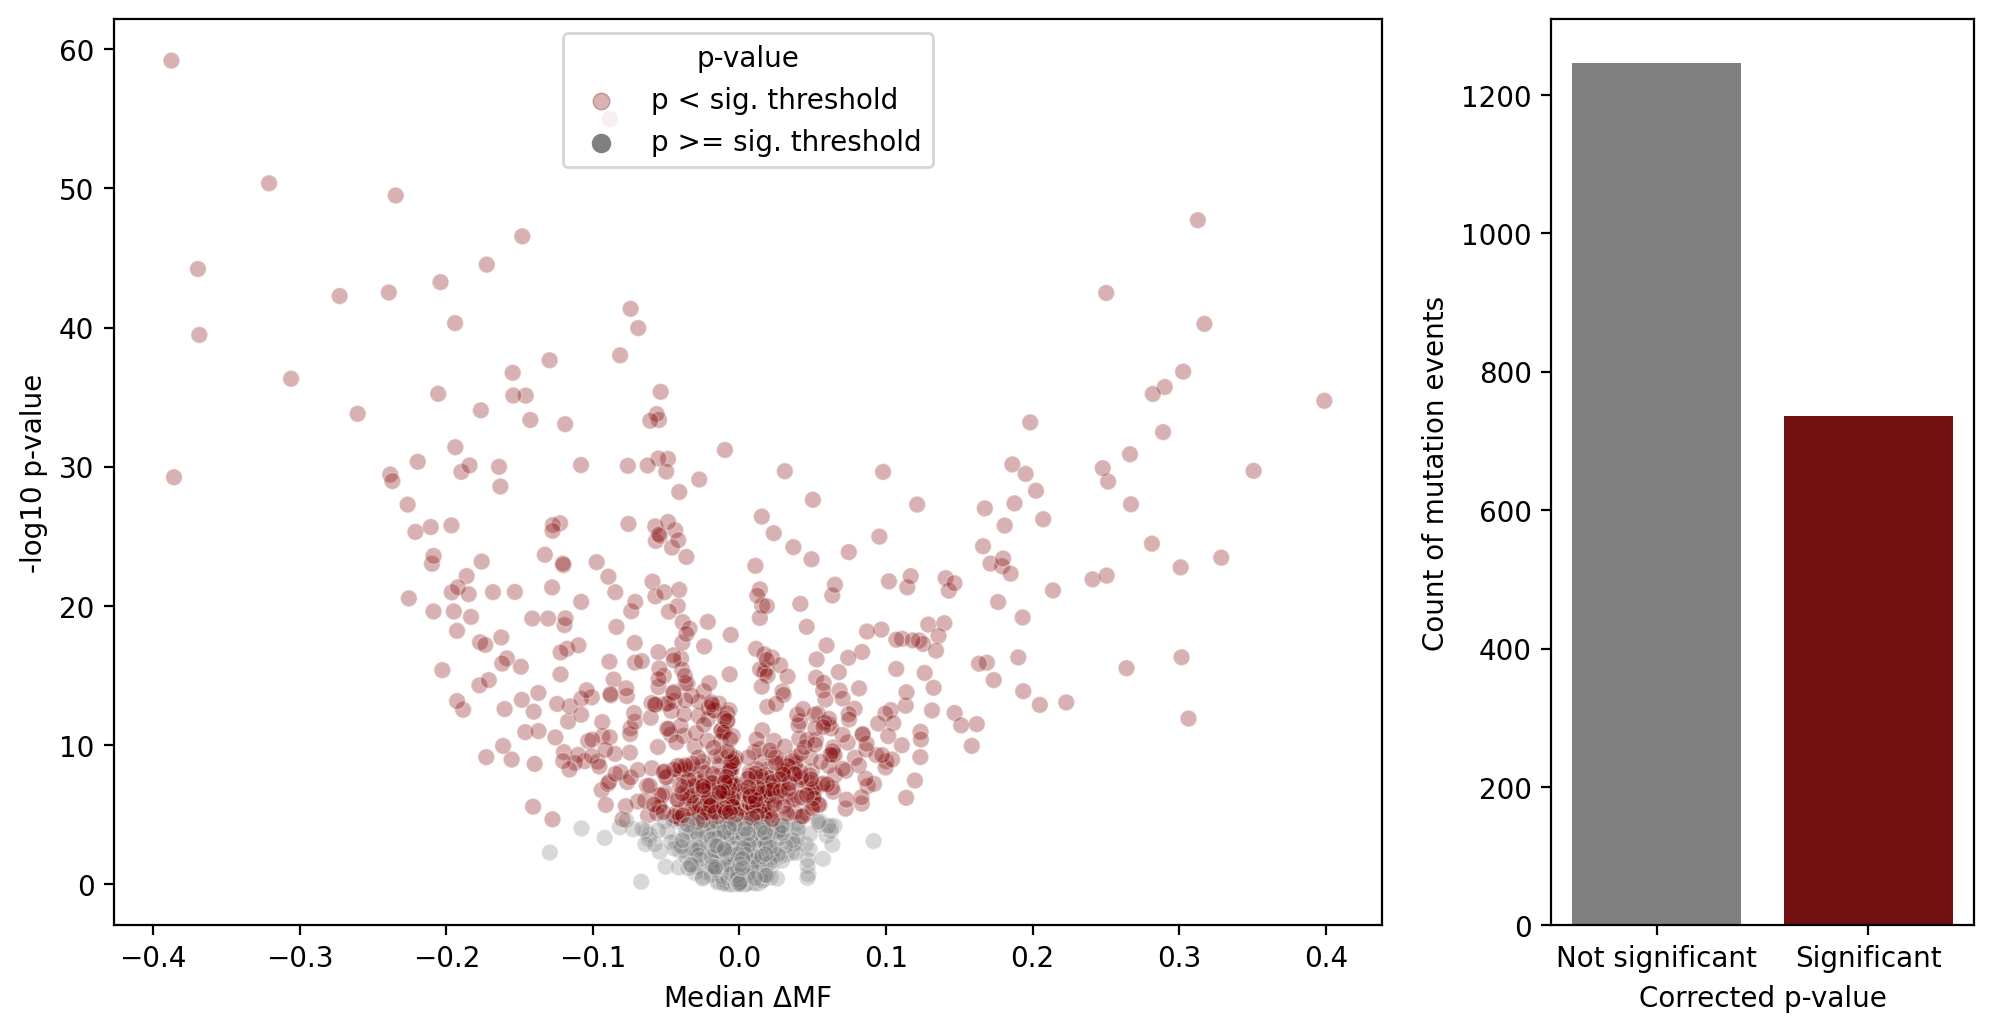

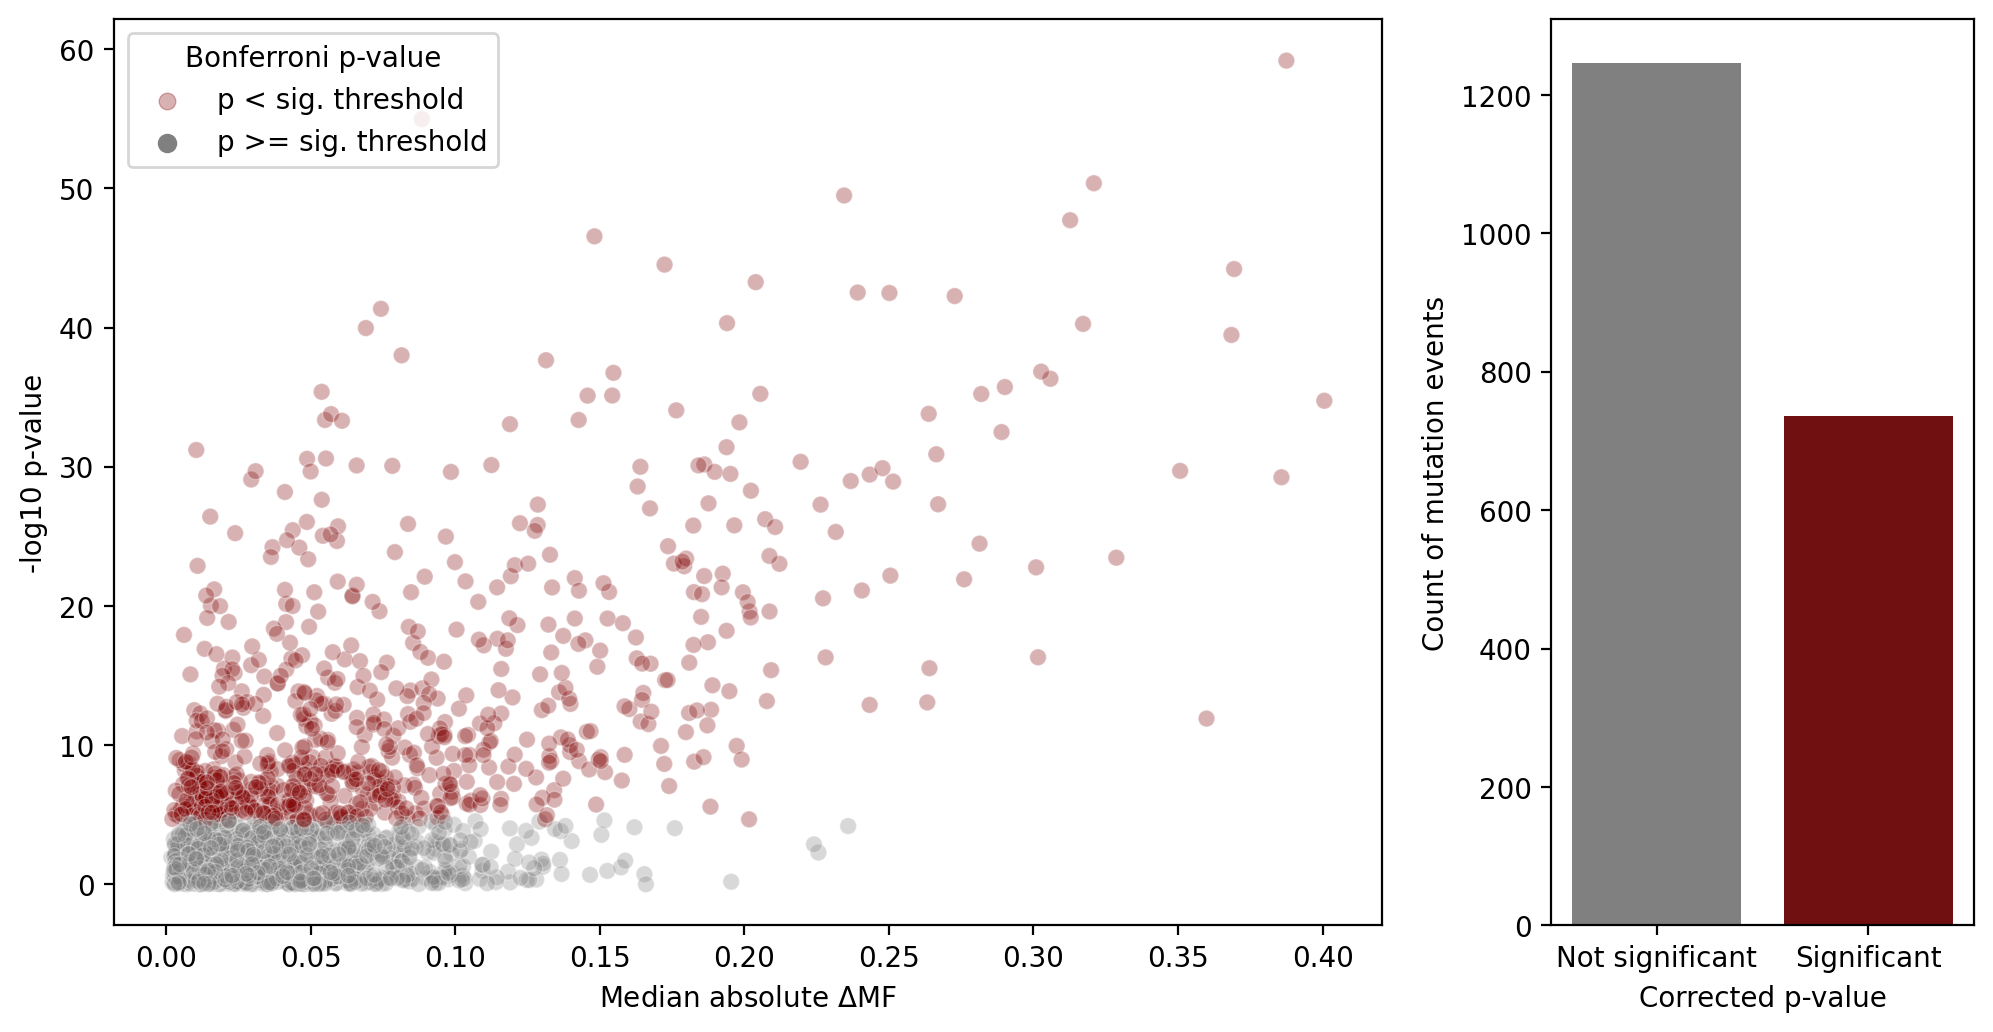

In [257]:
grouped_volc_metrics = mut_scan.volcano_plot(pos_all_metrics_df_corrected.loc[pos_all_metrics_df_corrected['mut_event'].isin(big_mut_delta_events)], pval_col = 'delta_mf_pval2', sig_col = 'delta_mf_pval2_sig_bonf')

In [243]:
pos_all_metrics_df_corrected_sorted = pos_all_metrics_df_corrected.loc[pos_all_metrics_df_corrected['mut_event'].isin(big_mut_delta_events), :].sort_values(by = 'delta_mf_pval2', ascending=True)

In [ ]:
grouped_volc_metrics.sort_values(by = 'log10_pval', ascending=False).head(20)

#id
cg25621286    -75833341
cg08543327    -74920299
cg08697251    -74539075
cg21964798    -74525691
cg20414364    -74420336
                ...    
cg26913563     96488977
cg17747551     98915842
cg01567482    100755368
cg24527008    101841283
cg23372684    101975735
Name: start, Length: 100, dtype: int64
Dropped 8 samples with mutations nearby


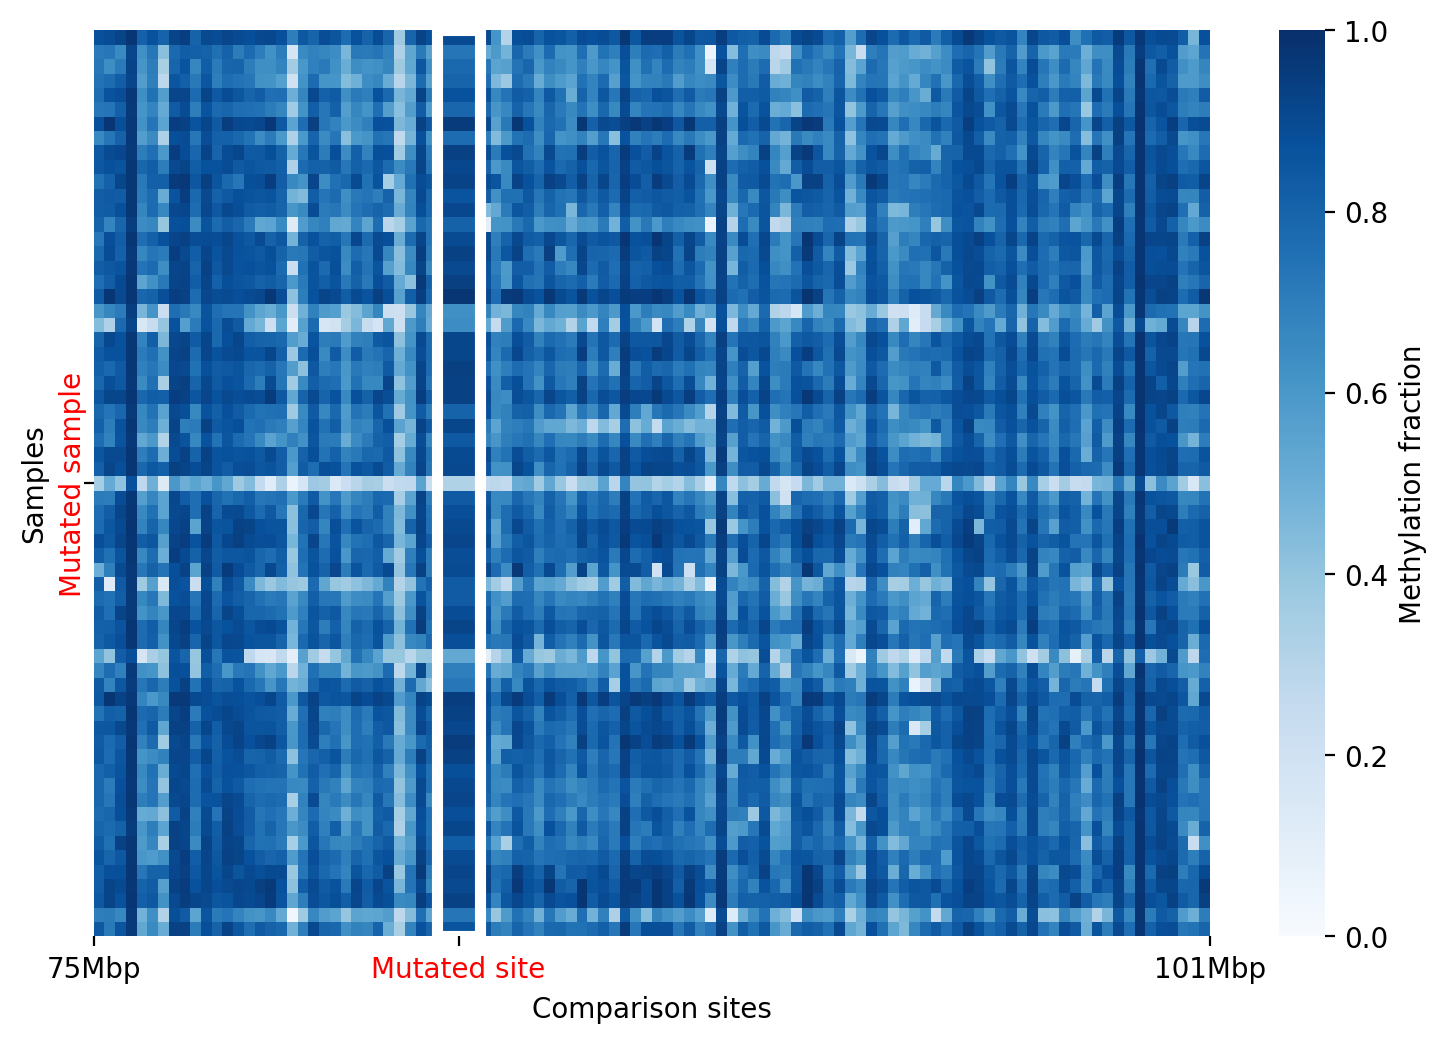

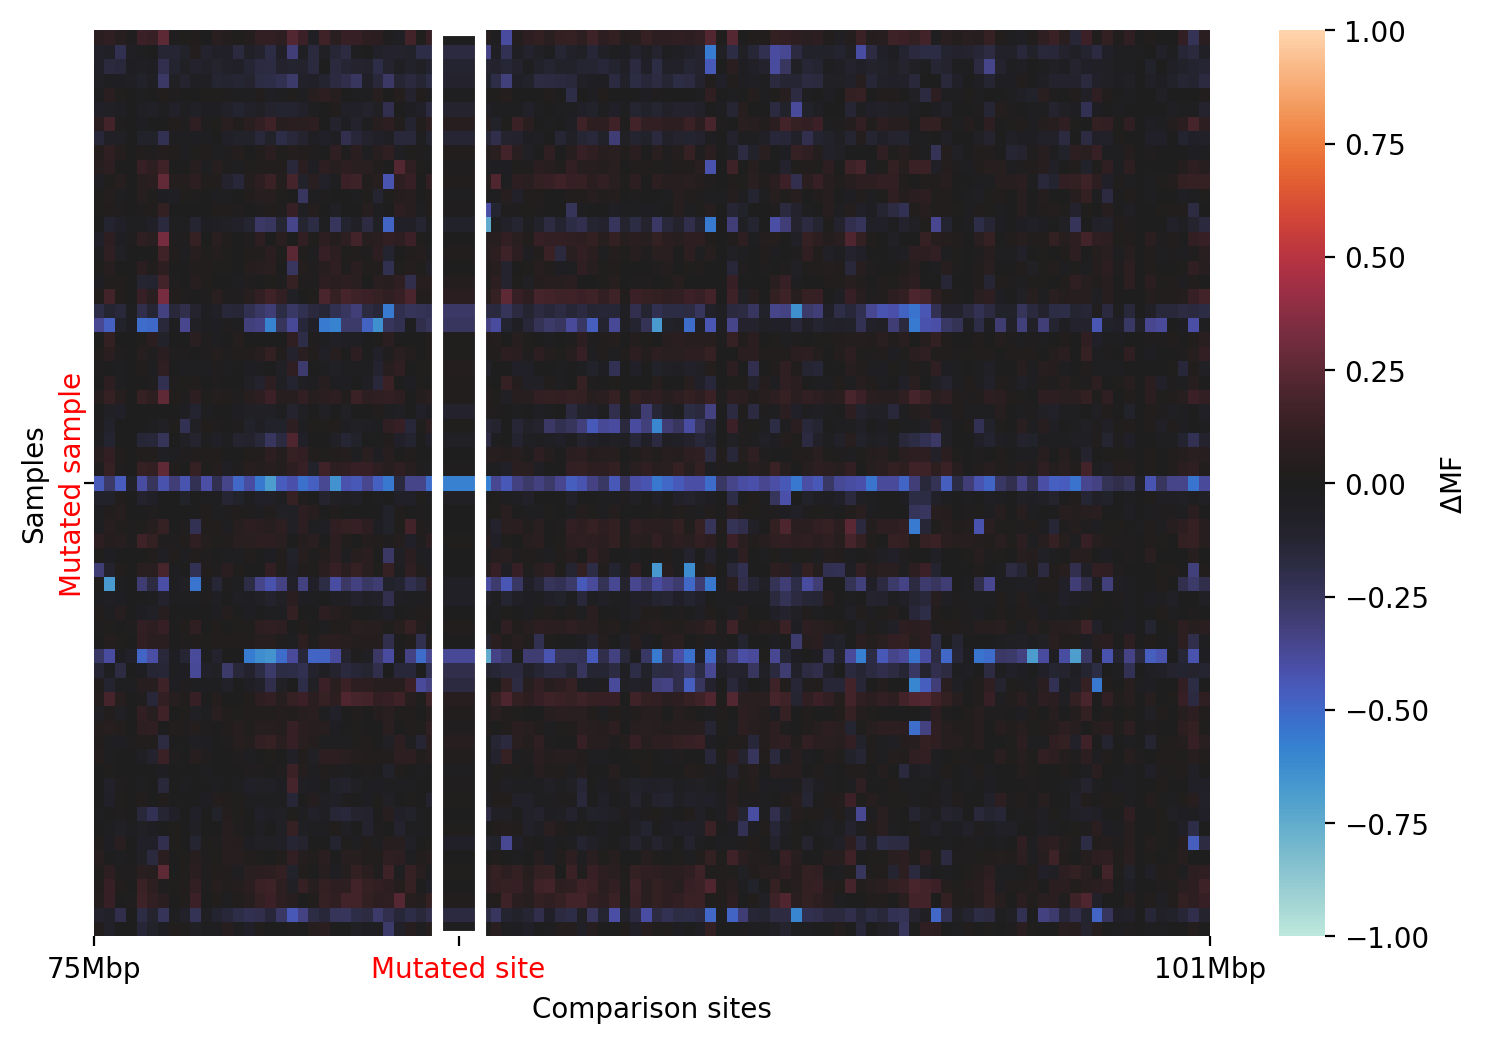

In [300]:
# TCGA-BR-A4QL_5:140514944
# TCGA-A5-A2K3_5:76028950
# TCGA-A6-6654_2:38301756
all_samples_comp_sites = mut_scan.corr_heatmap('TCGA-A5-A2K3_5:76028950', pos_comparison_sites_comb_df, distlim=250000000)

##### Empirical background

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_muts_df['abs_delta_mf_median'] = real_muts_df['delta_mf_median'].abs()


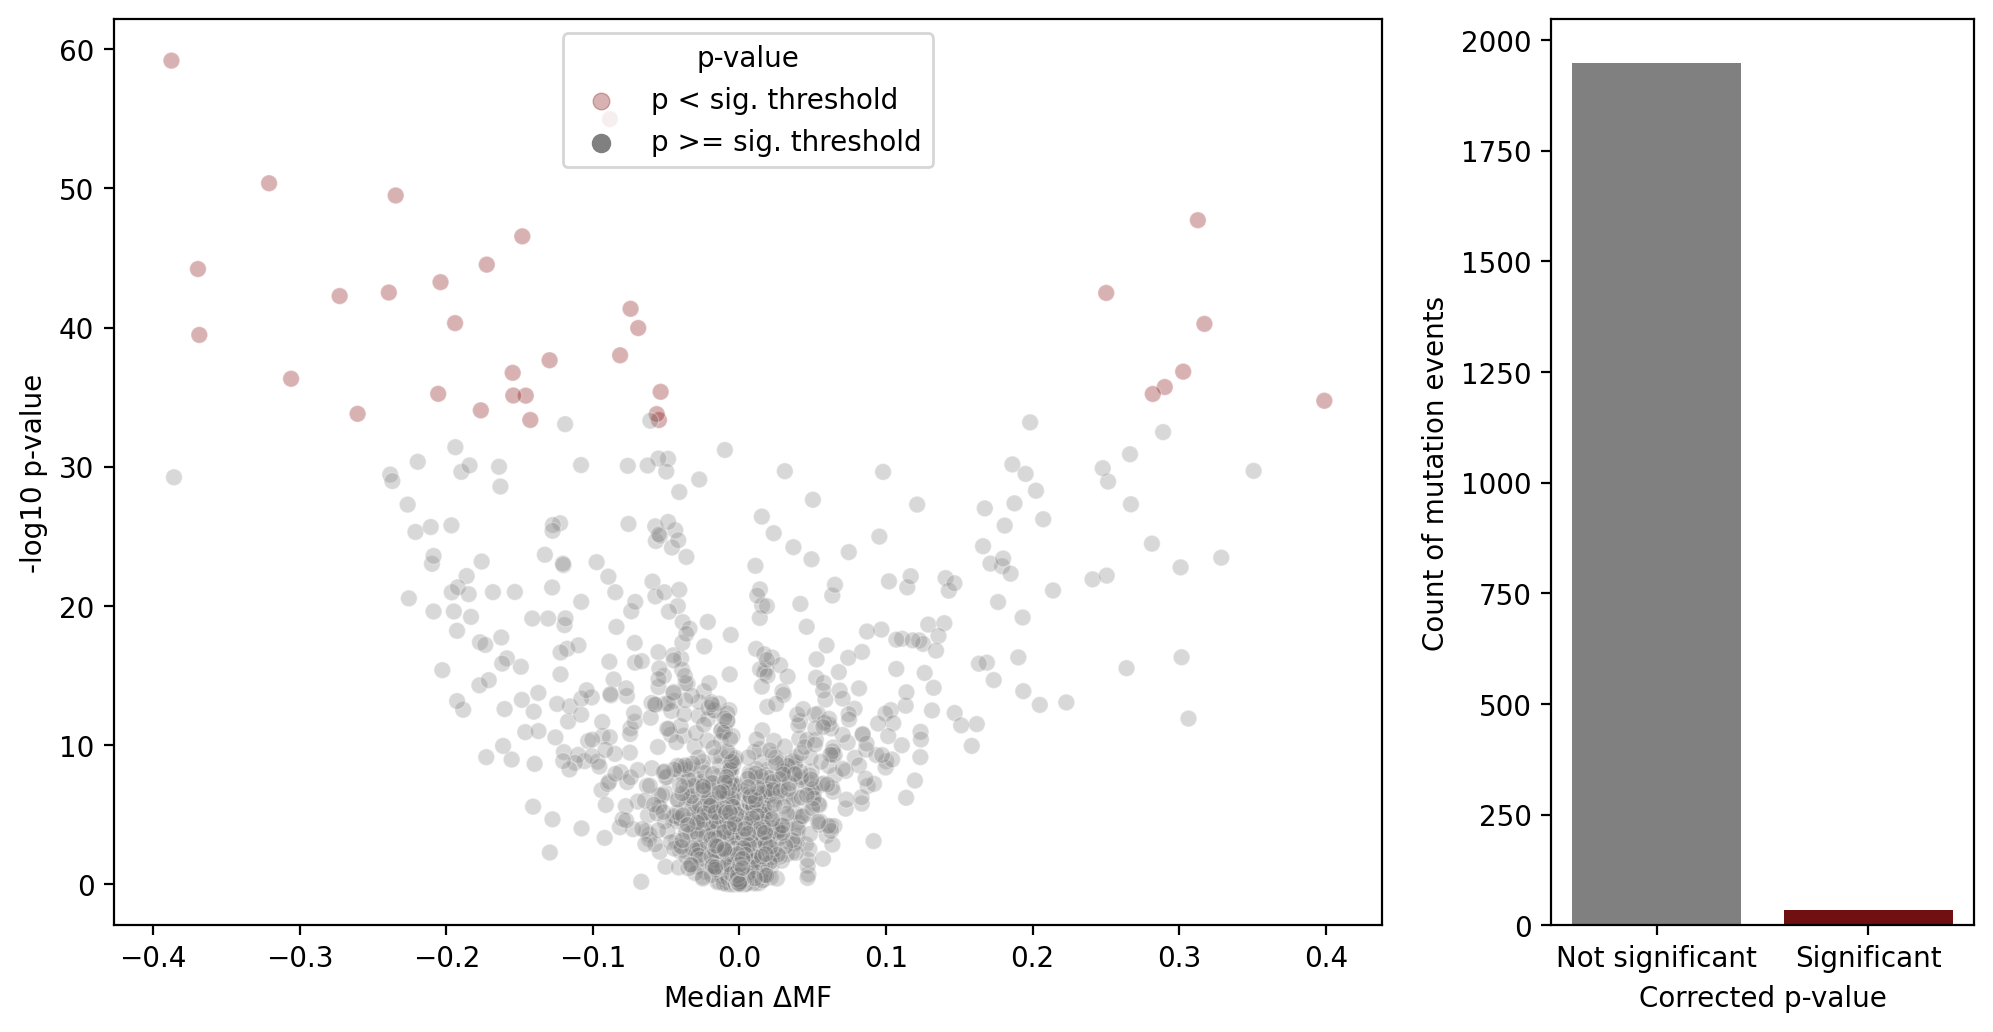

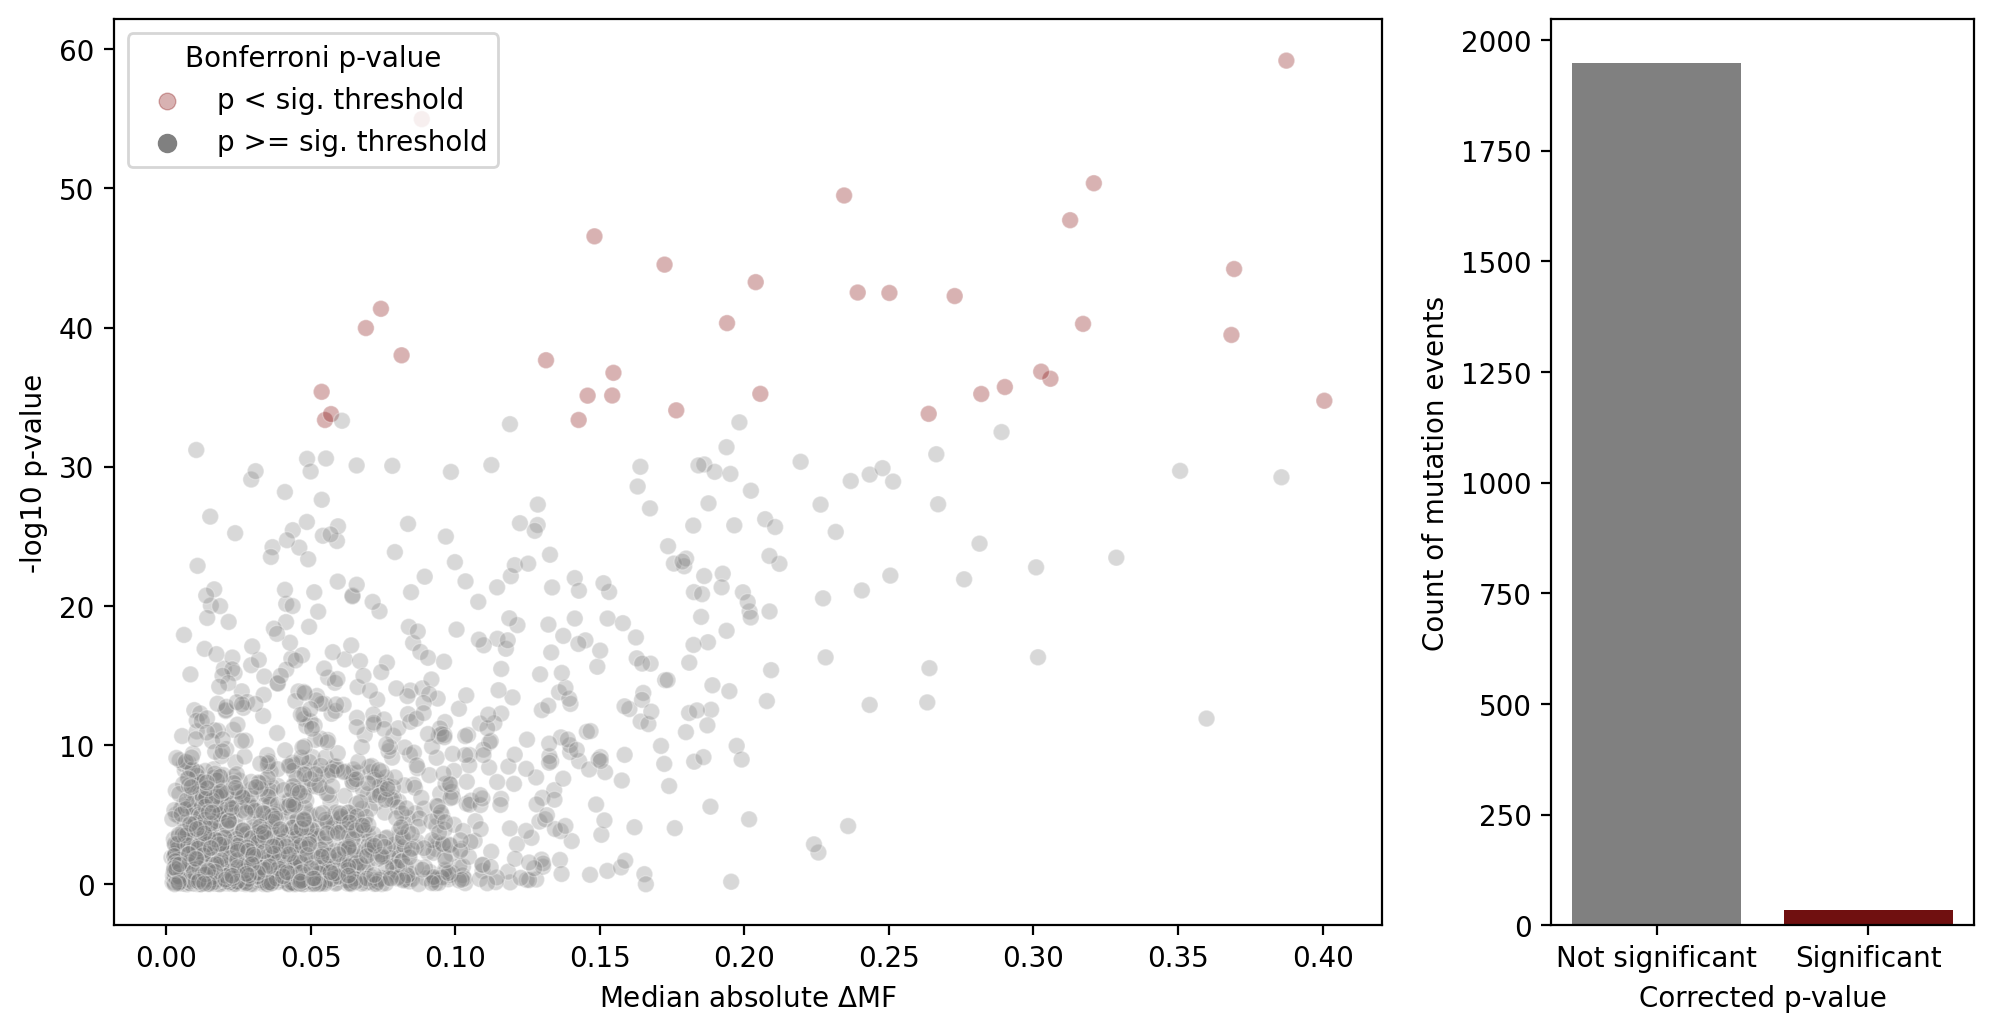

In [186]:
mut_scan.volcano_plot(pos_all_metrics_df_corrected.loc[pos_all_metrics_df_corrected['mut_event'].isin(big_mut_delta_events)], pval_col = 'delta_mf_pval2', sig_col = 'delta_mf_pval2_sig')

##### VAF and delta_mf at mut site vs resulting effect

Text(0, 0.5, 'delta_mf_pval2')

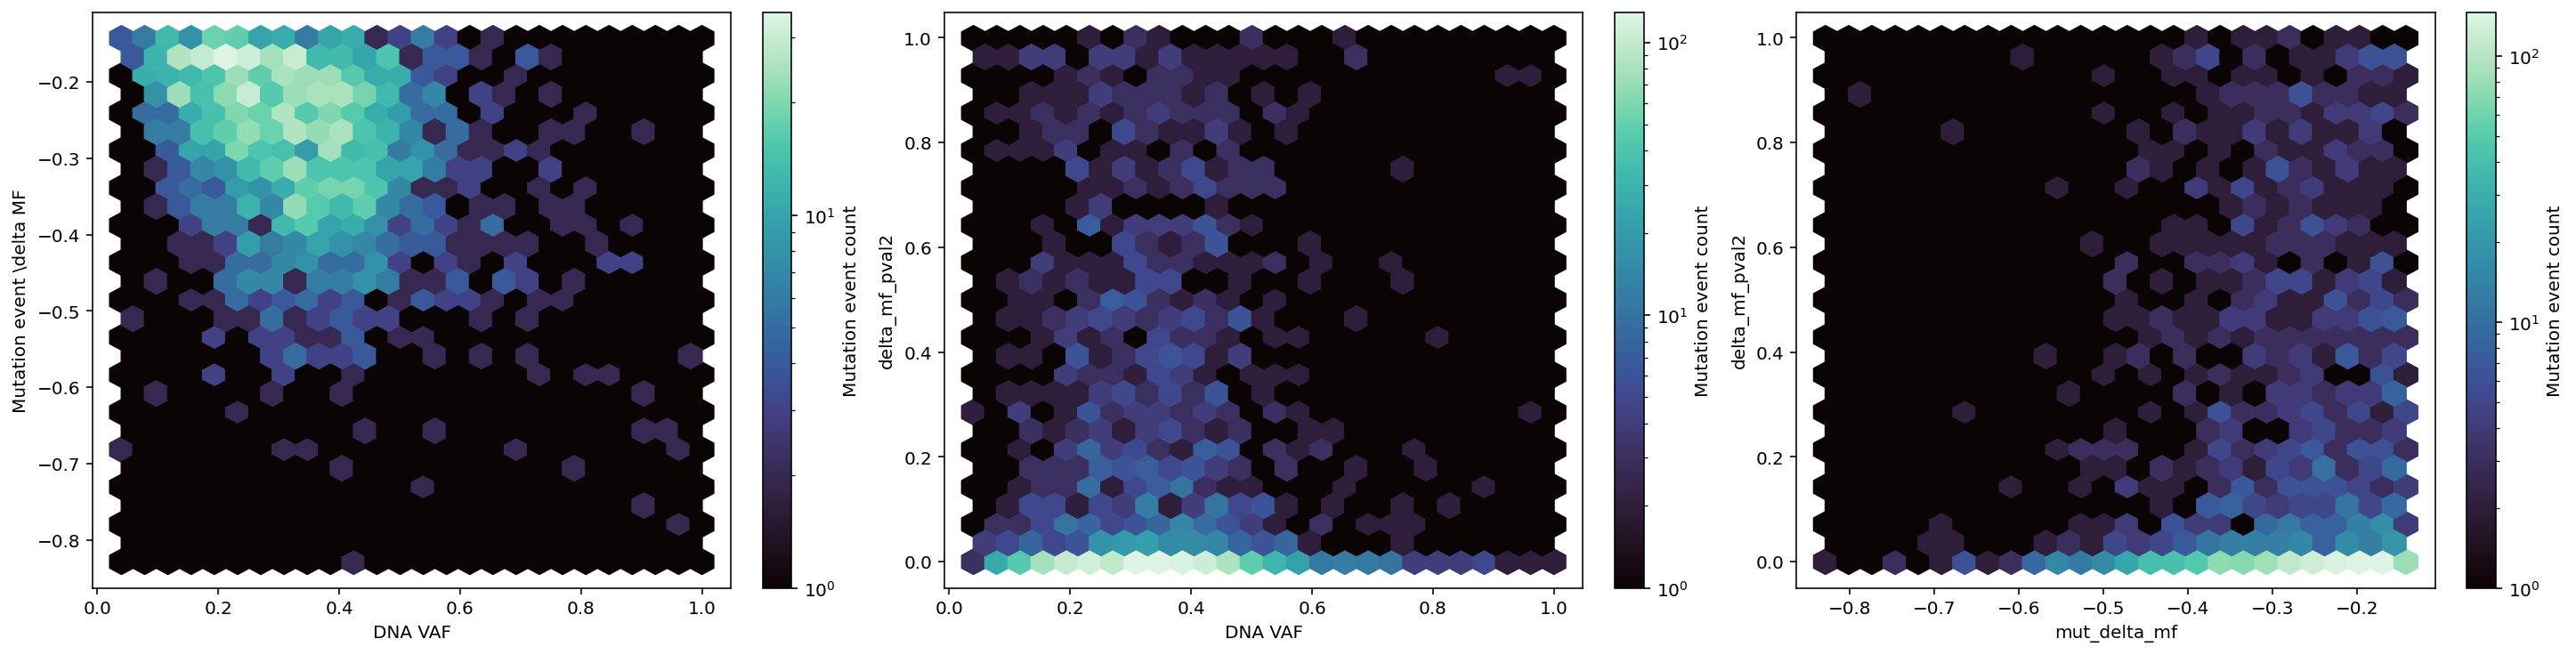

In [231]:
# effect vs VAF and delta_mf of mutated site
unique_real_muts = real_muts.drop_duplicates(subset=['mut_event'], keep='first')
pos_unique_real_muts = unique_real_muts.merge(pos_comparison_sites_comb_df.loc[pos_comparison_sites_comb_df['index_event'] == 'self', ['mut_event', 'DNA_VAF', 'mut_delta_mf']], on='mut_event', how='left')
# make second and fourth columns smaller width
# add space between subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
axes = axes.flatten()

axes[0].hexbin(x = pos_unique_real_muts['DNA_VAF'], y = pos_unique_real_muts['mut_delta_mf'], gridsize = 25, cmap = 'mako', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[0].collections[0], ax=axes[0], orientation='vertical', label='Mutation event count')
axes[0].set_xlabel('DNA VAF')
axes[0].set_ylabel(r'Mutation event \delta MF')

axes[1].hexbin(x = pos_unique_real_muts['DNA_VAF'], y = pos_unique_real_muts['delta_mf_pval2'], gridsize = 25, cmap = 'mako', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[1].collections[0], ax=axes[1], orientation='vertical', label='Mutation event count')
axes[1].set_xlabel('DNA VAF')
axes[1].set_ylabel(r'delta_mf_pval2')

# same for mut_delta_mf and delta_mf_pval2
axes[2].hexbin(x = pos_unique_real_muts['mut_delta_mf'], y = pos_unique_real_muts['delta_mf_pval2'], gridsize = 25, cmap = 'mako', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[2].collections[0], ax=axes[2], orientation='vertical', label='Mutation event count')
axes[2].set_xlabel('mut_delta_mf')
axes[2].set_ylabel(r'delta_mf_pval2')


In [ ]:
sns.scatterplot(data=unique_real_muts, x='DNA_VAF', y='mut_delta_mf', alpha=.5)
spearmanr(unique_real_muts['DNA_VAF'], unique_real_muts['mut_delta_mf'])
sns.scatterplot(data=unique_real_muts, x='DNA_VAF', y='delta_mf_pval2')
spearmanr(unique_real_muts['DNA_VAF'], unique_real_muts['delta_mf_pval2'])
sns.scatterplot(data=unique_real_muts, x='mut_delta_mf', y='delta_mf_pval2')
spearmanr(unique_real_muts['mut_delta_mf'], unique_real_muts['delta_mf_pval2'])

#### Neg corr

##### Bonferroni

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_muts_df['abs_delta_mf_median'] = real_muts_df['delta_mf_median'].abs()


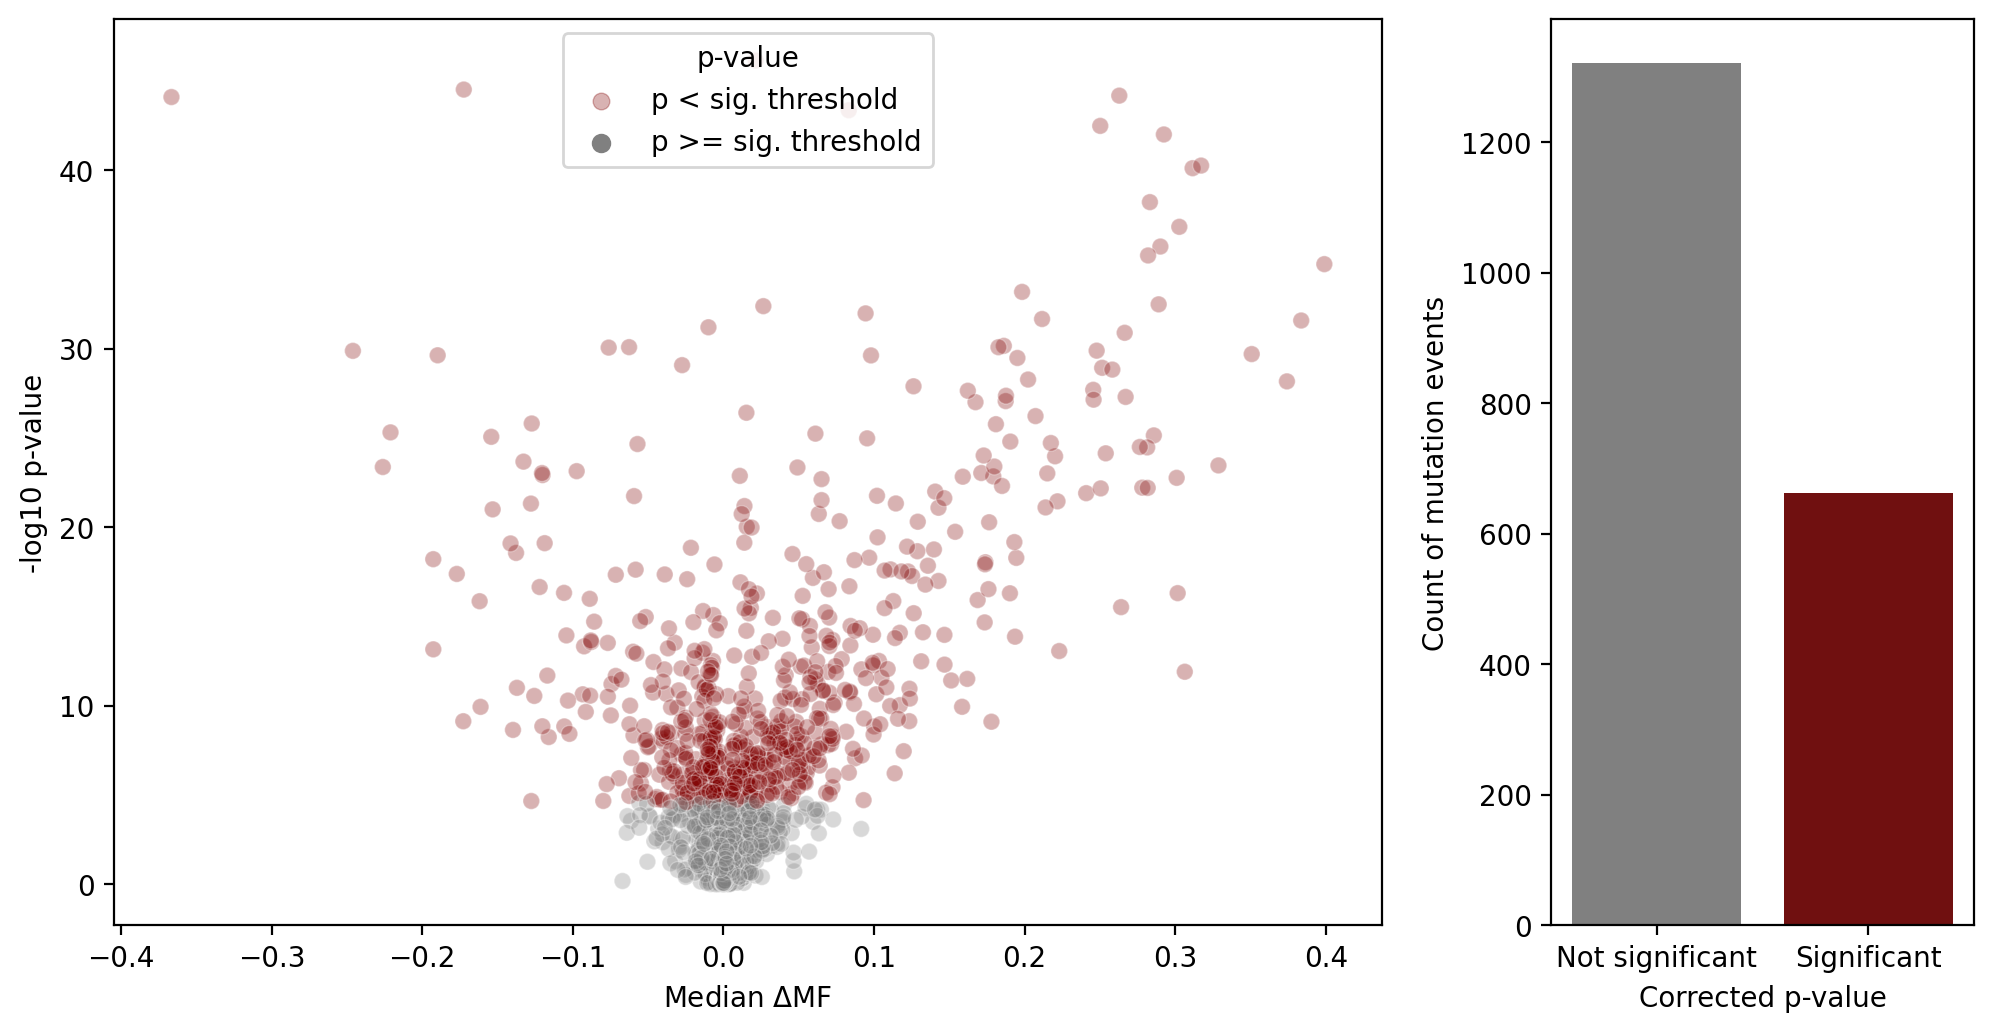

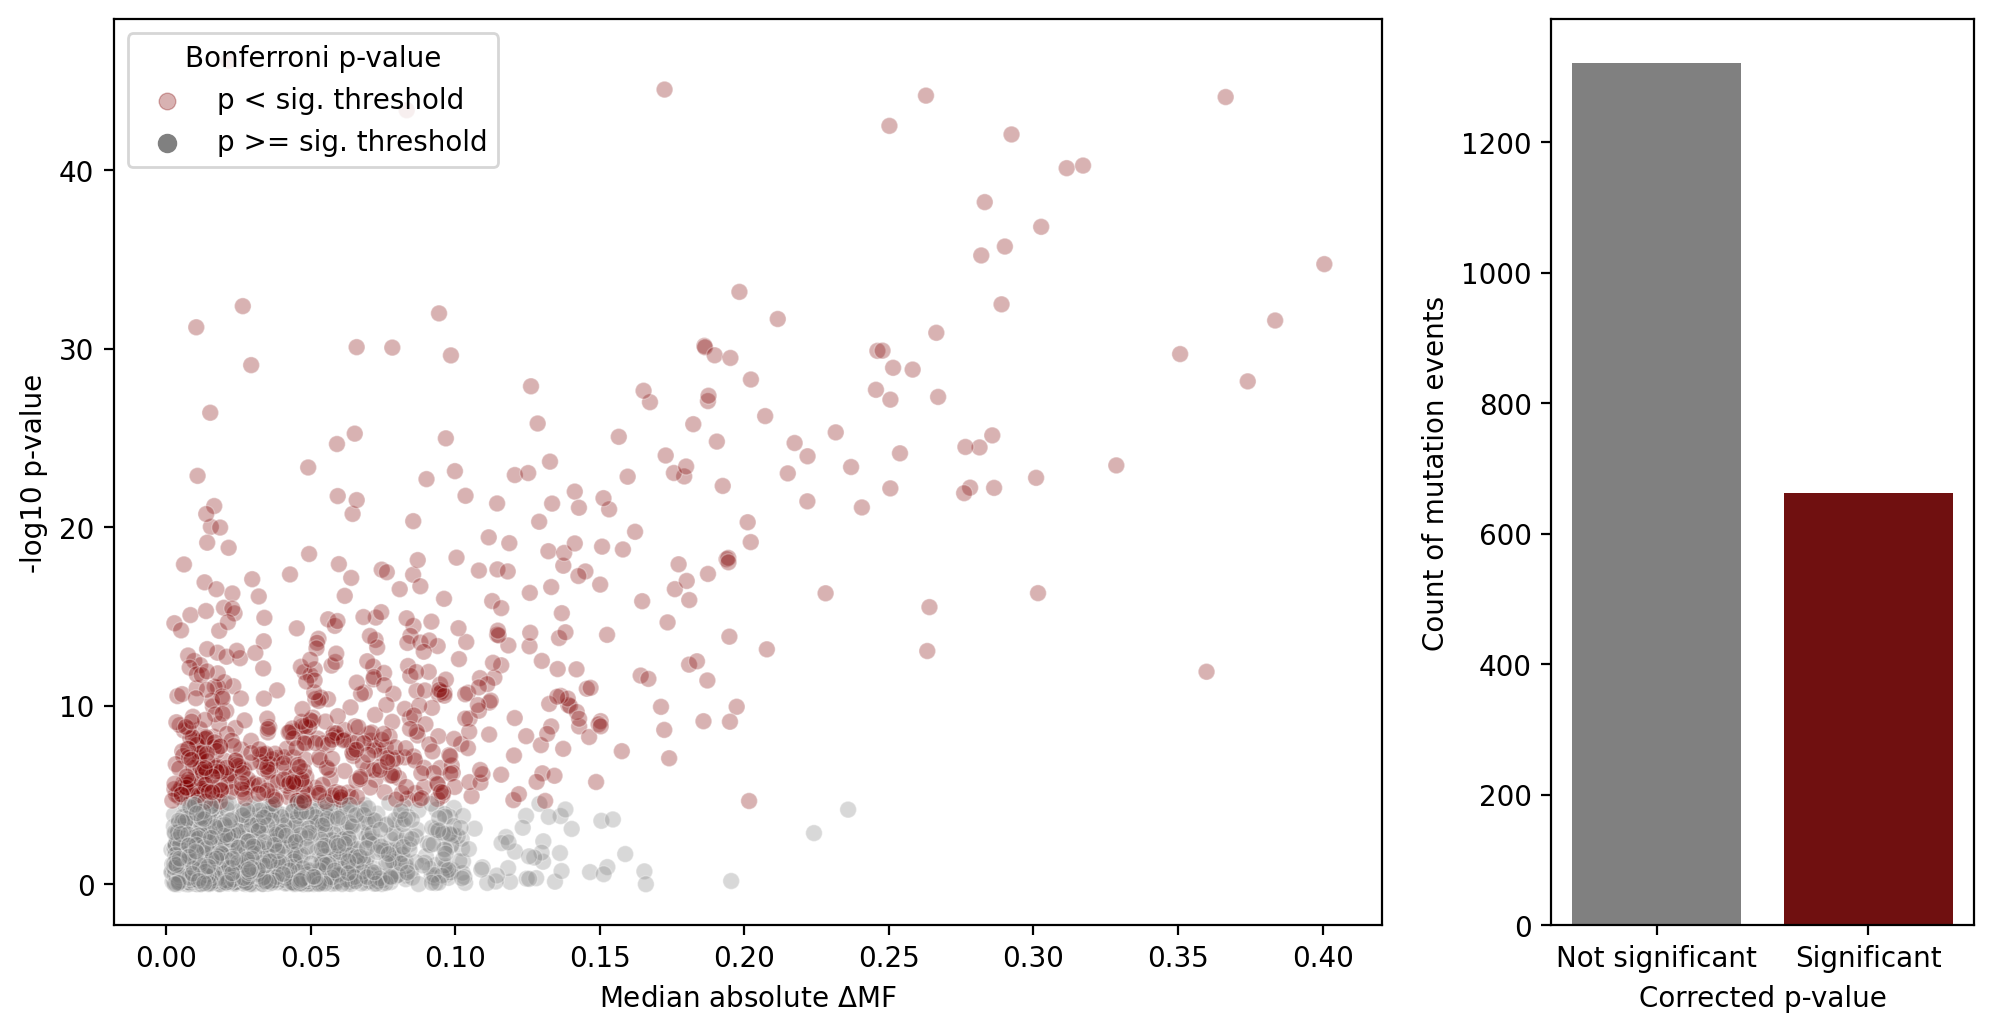

In [202]:
mut_scan.volcano_plot(neg_all_metrics_df_corrected.loc[neg_all_metrics_df_corrected['mut_event'].isin(big_mut_delta_events)], pval_col = 'delta_mf_pval2', sig_col = 'delta_mf_pval2_sig_bonf')

##### Empirical background

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_muts_df['abs_delta_mf_median'] = real_muts_df['delta_mf_median'].abs()


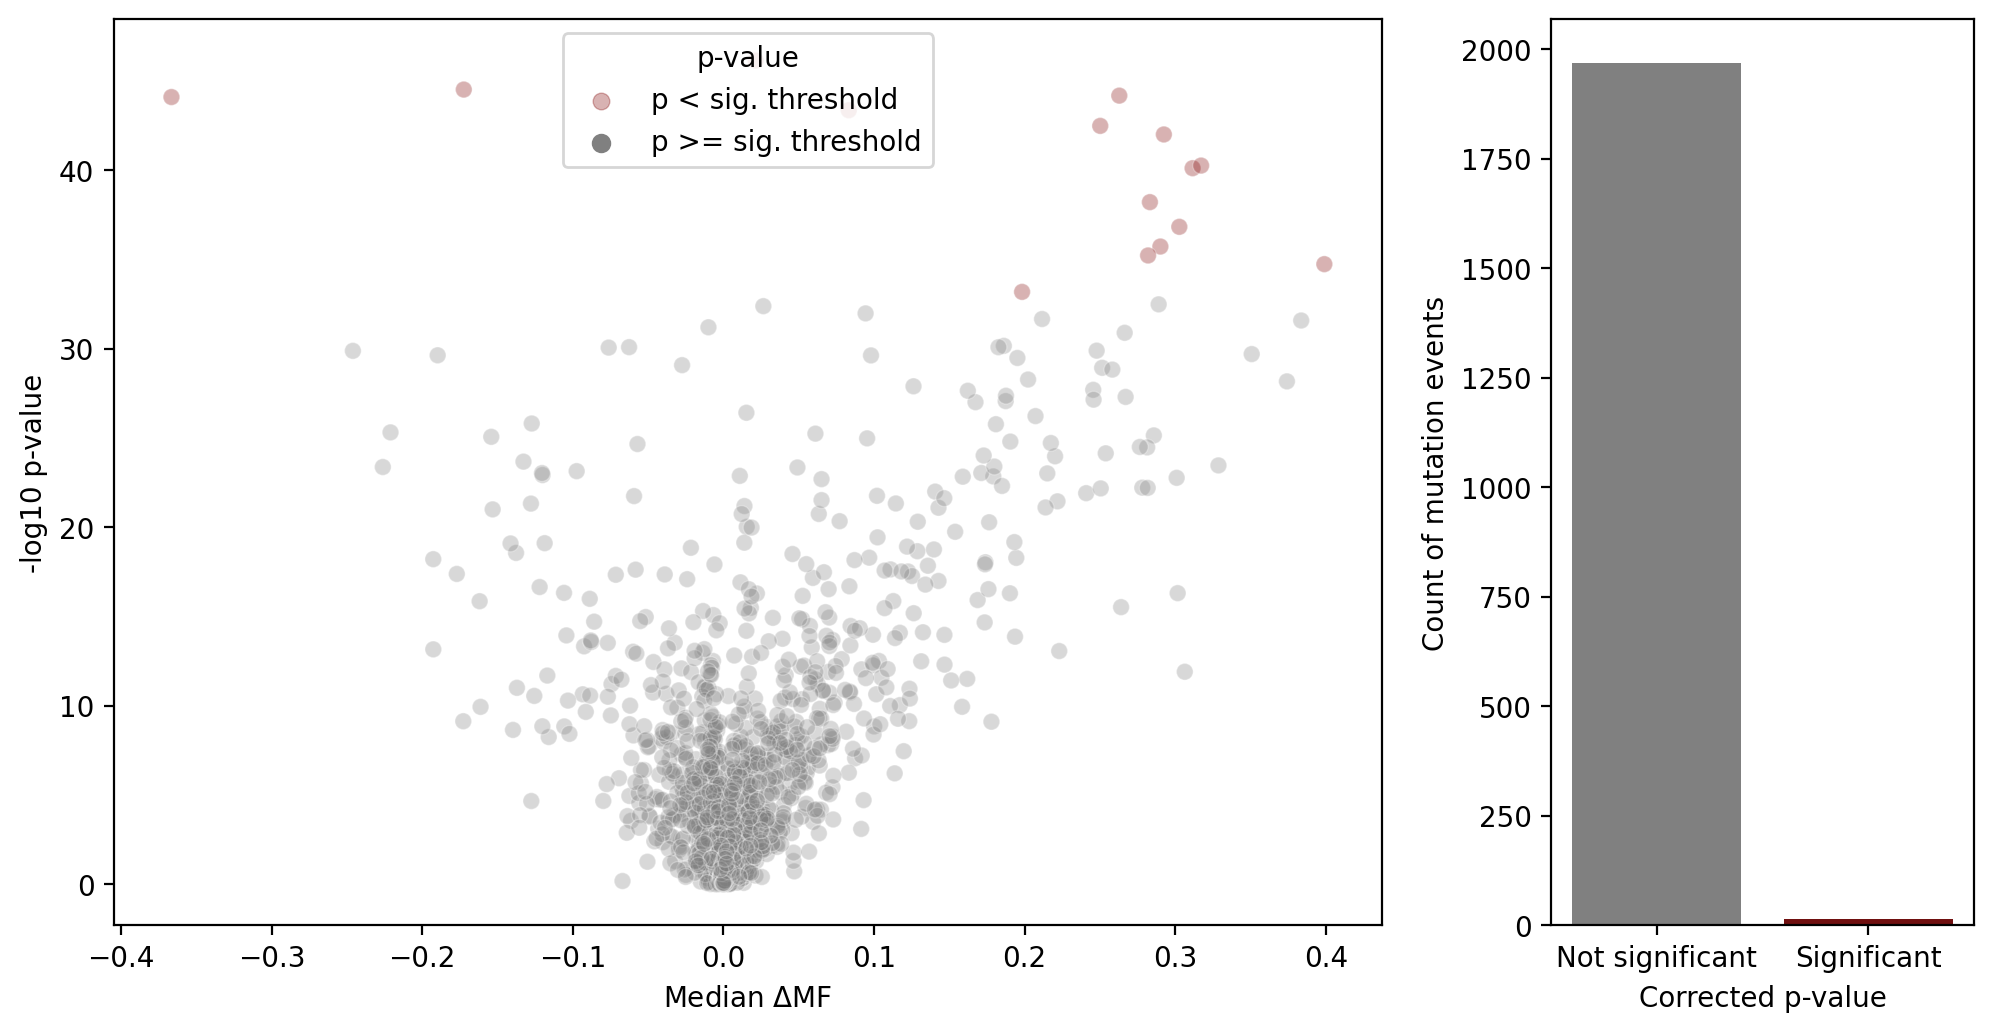

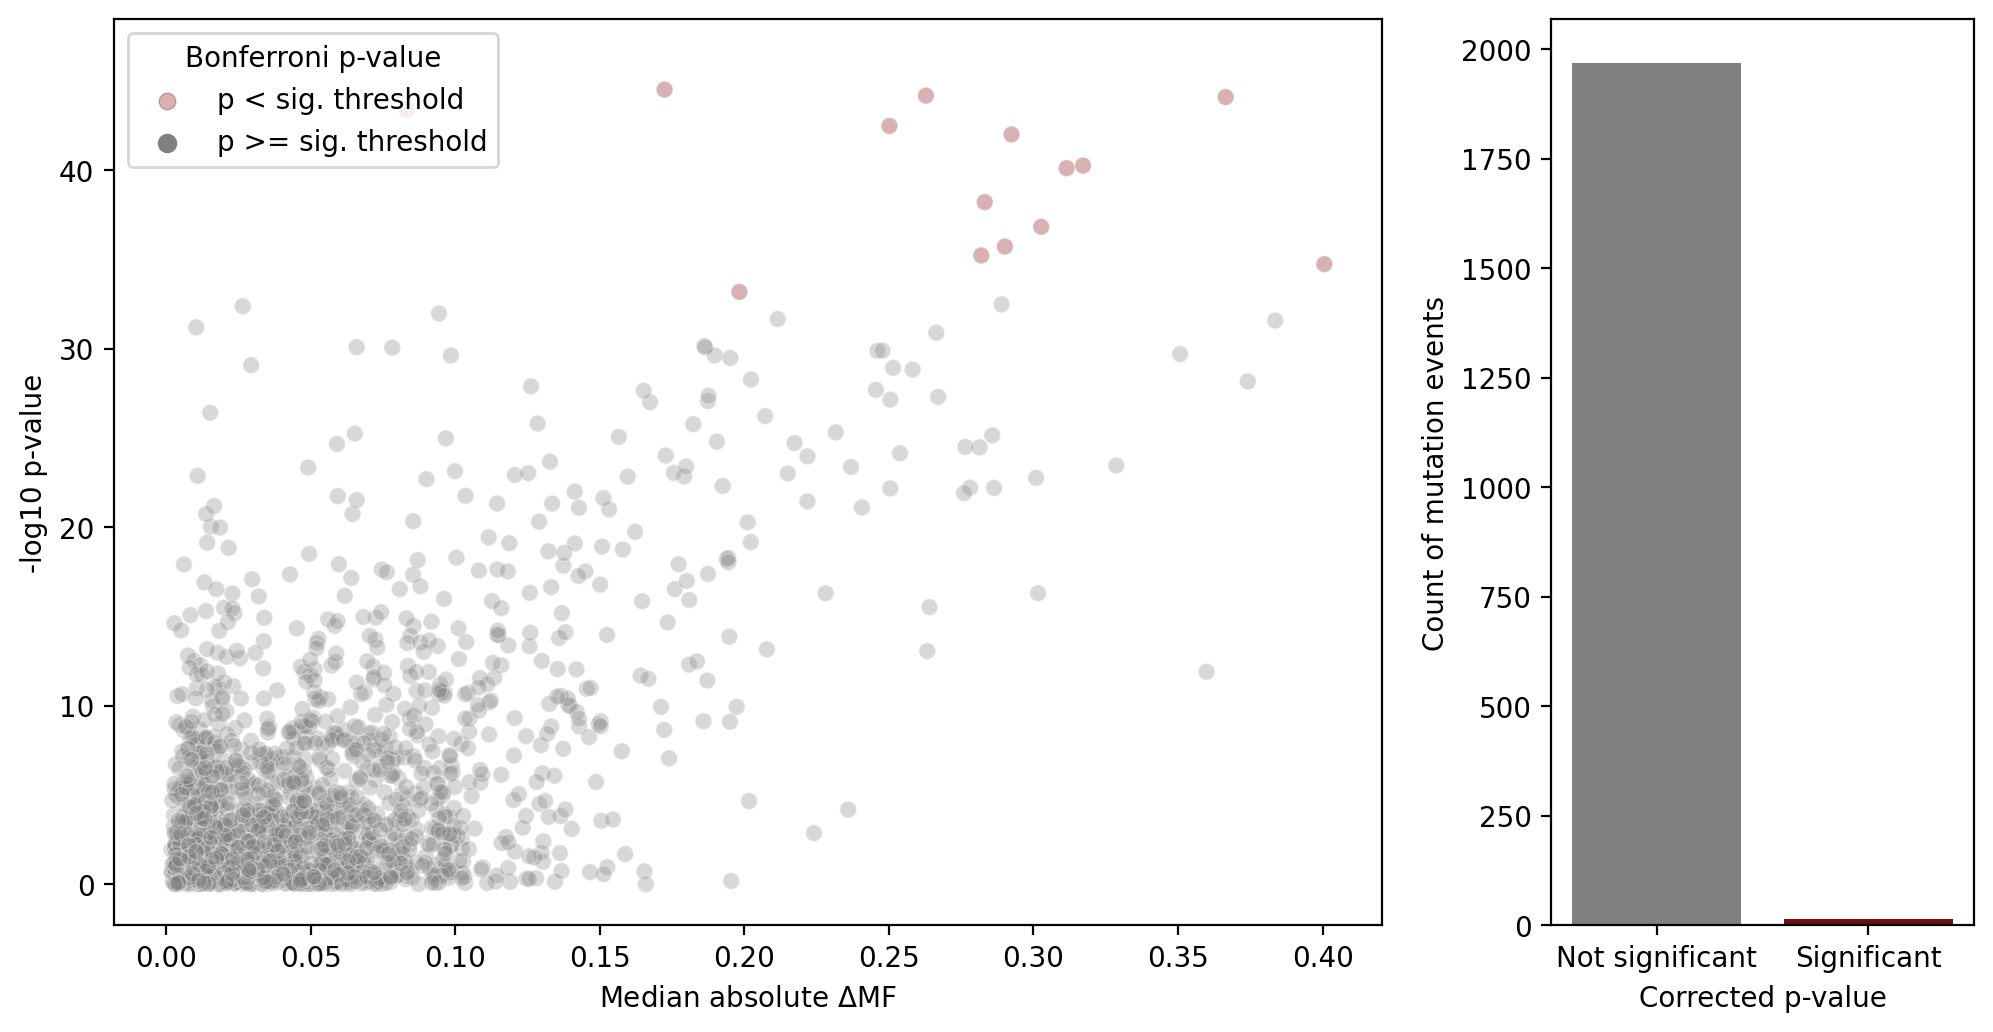

In [197]:
mut_scan.volcano_plot(neg_all_metrics_df_corrected.loc[neg_all_metrics_df_corrected['mut_event'].isin(big_mut_delta_events)], pval_col = 'delta_mf_pval2', sig_col = 'delta_mf_pval2_sig')

##### VAF and delta_mf at mut site vs resulting effect

Text(0, 0.5, 'delta_mf_pval2')

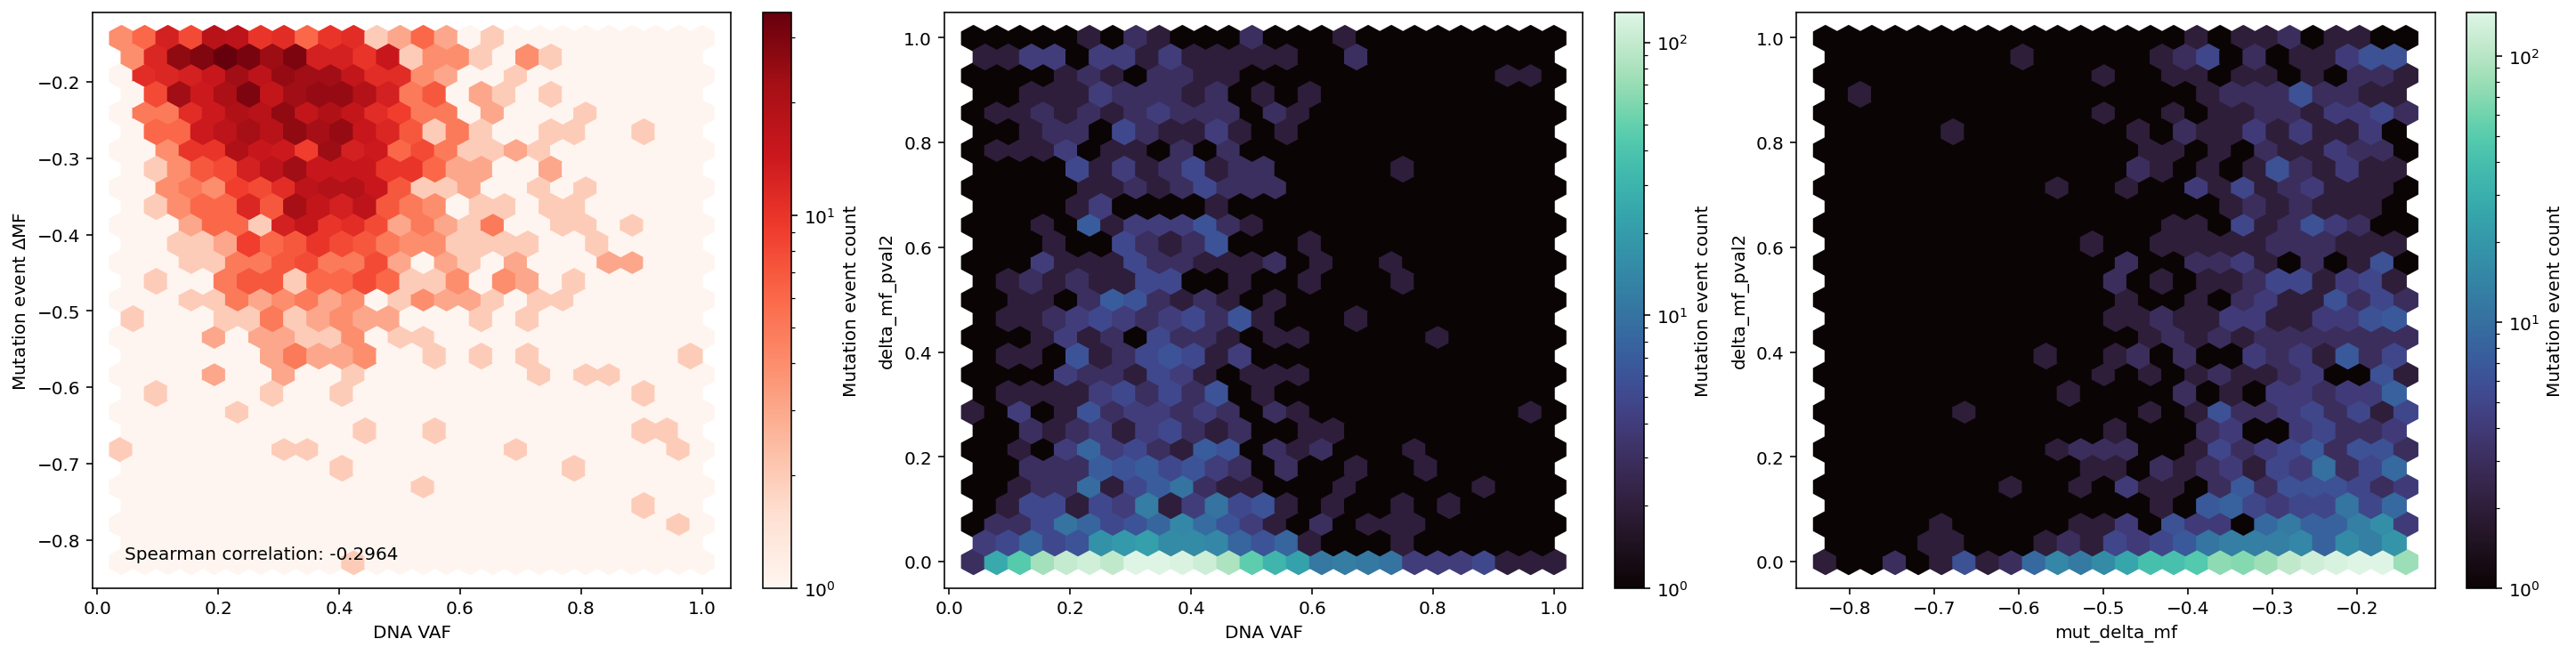

In [238]:
# effect vs VAF and delta_mf of mutated site
unique_real_muts = real_muts.drop_duplicates(subset=['mut_event'], keep='first')
neg_unique_real_muts = unique_real_muts.merge(neg_comparison_sites_comb_df.loc[neg_comparison_sites_comb_df['index_event'] == 'self', ['mut_event', 'DNA_VAF', 'mut_delta_mf']], on='mut_event', how='left')
# make second and fourth columns smaller width
# add space between subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
axes = axes.flatten()

axes[0].hexbin(x = neg_unique_real_muts['DNA_VAF'], y = neg_unique_real_muts['mut_delta_mf'], gridsize = 25, cmap = 'Reds', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[0].collections[0], ax=axes[0], orientation='vertical', label='Mutation event count')
axes[0].set_xlabel('DNA VAF')
axes[0].set_ylabel(r'Mutation event $\Delta$MF')
# add spearman correlaiton as text to plot
axes[0].text(0.05, 0.05, f"Spearman correlation: {spearmanr(neg_unique_real_muts['DNA_VAF'], neg_unique_real_muts['mut_delta_mf'])[0]:.4f}", transform=axes[0].transAxes)

axes[1].hexbin(x = neg_unique_real_muts['DNA_VAF'], y = neg_unique_real_muts['delta_mf_pval2'], gridsize = 25, cmap = 'mako', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[1].collections[0], ax=axes[1], orientation='vertical', label='Mutation event count')
axes[1].set_xlabel('DNA VAF')
axes[1].set_ylabel(r'delta_mf_pval2')

# same for mut_delta_mf and delta_mf_pval2
axes[2].hexbin(x = neg_unique_real_muts['mut_delta_mf'], y = neg_unique_real_muts['delta_mf_pval2'], gridsize = 25, cmap = 'mako', bins = 'log')
# add a colorbar
cbar = fig.colorbar(axes[2].collections[0], ax=axes[2], orientation='vertical', label='Mutation event count') 
axes[2].set_xlabel('mut_delta_mf')
axes[2].set_ylabel(r'delta_mf_pval2')

# 
